In [1]:
import scraper_eod as s
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import datetime
from datetime import date, timedelta
import matplotlib.pyplot as plt
import time
from scipy.stats import norm
import seaborn as sns
from yahoo_fin import options
from yahoo_fin.stock_info import *
from yahoo_fin.stock_info import get_data, get_splits
import mibian
import time
m = s.StockMongo()
import indicator_daily as i

C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)


In [4]:
o = i.Options('TSLA')
o.options

C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)


,contractName,contractSize,contractPeriod,currency,type,inTheMoney,lastTradeDateTime,expirationDate,strike,lastPrice,...,theoretical,intrinsicValue,timeValue,updatedAt,daysBeforeExpiration,iv,close,volatility,vix,date


<AxesSubplot:xlabel='rel_risk', ylabel='r'>

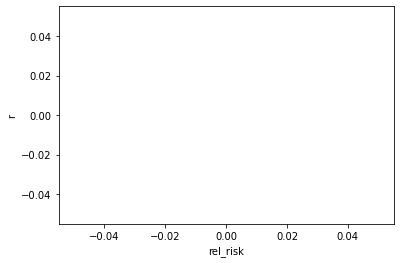

In [3]:
s = o.returns
#s[s.is_won].plot.scatter(x='probability', y='return')
#s.plot.scatter(x='rel_risk', y='return')
s[(s['rel_risk']>0)&(s['rel_risk']<3)&(s['r']>0)&(s['r']<2)].plot.scatter(x='rel_risk', y='r')
#o.strikeDates[0].volRange

In [4]:
s[(s['rel_risk']>0)&(s['rel_risk']<3)&(s['r']>0)&(s['r']<2)]

,strike_date,rel_risk,high_put,low_call,highStrike,lowStrike,p,r,ticker
0,2022-08-19,0.010000,0.23,0.48,9.0,20.0,0.408,1.769941,BE
16,2022-11-18,0.275000,0.85,2.75,12.0,22.0,0.408,1.160603,BE
17,2022-11-18,0.275000,0.45,2.75,10.0,22.0,0.544,1.043766,BE
18,2022-11-18,0.066667,0.30,0.55,9.0,30.0,0.680,1.562024,BE


In [2]:
#m = s.StockMongo()
analisys = m.stock_data.options_analisys.find()
tickers = []
for a in analisys:
    tickers.append(a['ticker'])

In [6]:
tickers[744]

'DVN'

In [ ]:
print("running data aggregation")
returns = []
for tick in tickers:
    try:
        o = i.Options(tick)
        s = o.returns
        s = s[(s['rel_risk']>0)&(s['rel_risk']<3)&(s['r']>0)&(s['r']<2)].copy()
        returns.append(s)
    except:
        print(tick)

running data aggregation


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\indicator_daily.py:289: RuntimeWarning: invalid value encountered in log
  r = f['y0'] + f['probability']*0.68 * self.vol_factor/0.5 + f['iv']*self.iv + f['vix']*self.vix + f['days_to_strike']*self.days_to_strike + f['sqr_rel_risk']*np.log(self.risk_rel)
C:\Users\ander\Documents\yahooScraper\indicator_daily.py:289: RuntimeWarning: invalid value encountered in log
  r = f['y0'] + f['probability']*0.68 * self.vol_factor/0.5 + f['iv']*self.iv + f['vix']*self.vix + f['days_to_strike']*self.days_to_strike + f['sqr_rel_risk']*np.log(self.risk_rel)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is dis

MVIS


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)


MGI


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\indicator_daily.py:289: RuntimeWarning: invalid value encountered in log
  r = f['y0'] + f['probability']*0.68 * self.vol_factor/0.5 + f['iv']*self.iv + f['vix']*self.vix + f['days_to_strike']*self.days_to_strike + f['sqr_rel_risk']*np.log(self.risk_rel)
C:\Users\ander\Documents\yahooScraper\indicator_daily.py:289: RuntimeWarning: invalid value encountered in log
  r = f['y0'] + f['probability']*0.68 * self.vol_factor/0.5 + f['iv']*self.iv + f['vix']*self.vix + f['days_to_strike']*self.days_to_strike + f['sqr_rel_risk']*np.log(self.risk_rel)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is dis

BAND


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)


MVIS


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)


MGI


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)


BAND


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)


BE


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yah

CC


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\indicator_daily.py:289: RuntimeWarning: invalid value encountered in log
  r = f['y0'] + f['probability']*0.68 * self.vol_factor/0.5 + f['iv']*self.iv + f['vix']*self.vix + f['days_to_strike']*self.days_to_strike + f['sqr_rel_risk']*np.log(self.risk_rel)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x

CHGG


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yah

CRSP


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yah

C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)


LAC


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yah

RIO


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)


SPG


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yah

MGI


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)


BAND


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)


A


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)


ABC


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yah

NKE


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yah

AI


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)


NOW


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)


ISRG


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)


ATER


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)


AMC


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yah

CHGG


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yah

CRSP


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yah

LAC


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yah

ALK


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yah

AMC


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)


AMR


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yah

ATER


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)


BBIG


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)


AUPH


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)


BE


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yah

CHGG


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yah

CRSP


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yah

ALK


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)


AUPH


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)


AMR


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)


BBIG


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)


BE


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yah

C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yah

SPG


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yah

MGI


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)


BAND


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)


A


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)


ABC


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yah

NKE


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yah

T


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yah

CHGG


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yah

CRSP


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yah

AI


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yah

ALK


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)


AMC


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)


AMR


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yah

ATER


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)


BBIG


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)


AUPH


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)


BE


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yah

CHGG


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yah

CRSP


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yah

LAC


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yah

C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yah

RIO


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)


SPG


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yah

In [4]:
b = pd.concat(returns)

In [5]:
b.sort_values(by=['r'])

,strike_date,rel_risk,high_put,low_call,highStrikePut,lowStrikeCall,lowStrikePut,highStrikeCall,p,r,ticker
15,2022-09-16,0.044000,0.05,0.22,50.0,170.0,55.0,175.0,1.360,0.047855,VLO
13,2022-09-16,0.012000,0.02,0.07,3.0,35.0,8.0,40.0,1.088,0.052669,MRO
8,2022-09-16,0.002333,2.15,0.13,180.0,260.0,180.0,290.0,0.408,0.104923,HON
10,2022-09-16,0.035000,0.49,1.10,115.0,260.0,115.0,270.0,0.680,0.107414,MRNA
8,2022-09-16,0.090000,1.15,2.00,35.0,90.0,35.0,100.0,0.408,0.118419,NVAX
...,...,...,...,...,...,...,...,...,...,...,...
9,2022-09-16,0.006286,0.30,0.14,37.5,50.0,37.5,67.5,0.544,1.711274,WFC
13,2022-09-16,0.005000,0.08,0.04,18.0,41.0,18.0,43.0,1.088,1.777953,BP
13,2022-09-16,0.002000,0.07,0.04,30.0,85.0,30.0,90.0,1.088,1.793918,MRVL
14,2022-09-16,0.000400,0.12,0.03,50.0,125.0,50.0,150.0,1.224,1.814779,TSM


In [6]:
c = b[(b['rel_risk']>0.25)&(b['p']>0.5)].copy()

In [7]:
c.sort_values(by=['r'])

,strike_date,rel_risk,high_put,low_call,highStrikePut,lowStrikeCall,lowStrikePut,highStrikeCall,p,r,ticker
9,2022-09-16,0.304,2.3,3.14,110.0,210.0,115.0,215.0,0.544,0.378827,SNOW


In [11]:
m.get_analisys("SNOW")[0]

{'_id': ObjectId('62dcedf1a27e6984c7f9bb16'),
 'y0': 0.16508356620980702,
 'sqr_rel_risk': -0.23015109851981644,
 'probability': -0.9087906733509796,
 'iv': -0.015919224519096872,
 'vix': 0.06563407867258961,
 'days_to_strike': 0.0015224368128135986,
 'ticker': 'SNOW',
 'date': datetime.datetime(2022, 7, 24, 0, 0)}